# Temporary Notebook for testing ContourGraph and RegionSlice creation


In [1]:
from collections import defaultdict
from collections import Counter

import pandas as pd
from shapely.geometry import Polygon


In [2]:
# Local functions and classes
from types_and_classes import *
from utilities import *
from contours import *
from contour_graph import *
from debug_tools import *
#from structures import *
from region_slice import *
#from structure_set import *
from relations import *


### Global Settings

In [3]:
PRECISION = 2

In [4]:
%matplotlib inline

# RegionSlice Not Including Island

In [5]:
box10x5 = box_points(10,5)
circle4_left = circle_points(2, offset_x=-3)
circle3_right = circle_points(1.5, offset_x=3)
circle2_left = circle_points(1, offset_x=-3, offset_y=0.5)
circle2_right = circle_points(1, offset_x=3)
slice_data = [
    ContourPoints(box10x5, roi=0, slice_index=1.0),
    ContourPoints(circle4_left, roi=0, slice_index=1.0),
    ContourPoints(circle3_right, roi=0, slice_index=1.0),
    ContourPoints(circle2_right, roi=0, slice_index=1.0),
    ContourPoints(circle2_left, roi=1, slice_index=1.0)
    ]
contour_table, slice_sequence = build_contour_table(slice_data)
contour_graph_a, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=0)
contour_graph_b, slice_sequence = build_contour_graph(contour_table,
                                                    slice_sequence,
                                                    roi=1)


In [6]:
contour_lookup = build_contour_lookup(contour_graph_a)

contour_lookup.loc[contour_lookup.ROI==0, ['SliceIndex', 'HoleType', 'Label']]

,SliceIndex,HoleType,Label
0,1.0,None,"(0, 1.0, 0)"
1,1.0,Unknown,"(0, 1.0, 1)"
2,1.0,Unknown,"(0, 1.0, 2)"
3,1.0,None,"(0, 1.0, 3)"


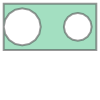

In [7]:
selected_label = contour_lookup.Label.iloc[0]
this_contour = contour_graph_a.nodes(data=True)[selected_label]['contour']
this_contour.polygon_with_holes

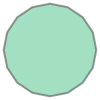

In [8]:
island_contour = contour_graph_a.nodes(data=True)[contour_lookup.Label.iloc[3]]['contour']
island_contour.polygon_with_holes

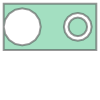

In [9]:
shapely.union_all([this_contour.polygon_with_holes, island_contour.polygon_with_holes])

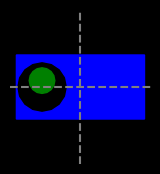

In [10]:
a = RegionSlice(contour_graph_a, slice_index=1.0)
b = RegionSlice(contour_graph_b, slice_index=1.0)
ax = plot_ab(a.regions['0A'], b.regions['1A'])
plt.show()

In [11]:
len(a.regions)

1

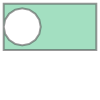

In [12]:
[r for r in a.regions.values()][0]

In [13]:
c_list = [r for r in a.embedded_regions.values()][0]
#c_list


In [14]:
poly_list = [c.polygon for c in c_list]
#poly_list

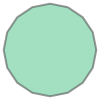

In [15]:
shapely.union_all(poly_list)

In [ ]:
def get_region_contours(contour_graph: nx.Graph,
                        contour_reference: pd.DataFrame,
                        related_regions: List[RegionIndex])->List[Contour]:
    '''Return the contours for the specified regions.'''
    region_selection = contour_reference['RegionIndex'].isin(related_regions)
    region_reference = contour_reference.loc[region_selection]
    contour_labels = region_reference['Label'].tolist()
    contour_data = dict(contour_graph.nodes.data('contour'))
    region_contours = [contour_data[label] for label in contour_labels]
    return region_contours

In [17]:
slice_index = 1.0
selected_contours = contour_lookup['SliceIndex'] == slice_index
reference_columns = ['Label', 'RegionIndex',
                        'HoleType', 'Interpolated', 'Boundary']
contour_reference = contour_lookup.loc[selected_contours,
                                        reference_columns]
region_set = set(contour_reference.RegionIndex)

In [18]:
region_set

{'0A', '0B', '0C', '0D'}

- `pop()` from list seems to always take the first `list` element, but and arbitrary `set` element.
- Does order matter?

In [19]:
list(region_set).pop()

'0A'

In [20]:
region_index = region_set.pop()
region_index

'0C'

In [ ]:
region_contours = get_region_contours(contour_graph_a, contour_reference,
                                      [region_index])
region_contours

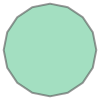

In [22]:
region_contours[0].polygon

In [23]:
region_contours[0].is_hole

True

In [24]:
related_contours_indexes = set()
for contour in region_contours:
    related_contours_indexes.update(set(contour.related_contours))
related_contours_indexes

{(0, 1.0, 0), (0, 1.0, 3)}

# ERROR Using degree = 1 to identify boundaries will miss cases where there is a bifurcation in the contour.

- Crashing here because a boundary contour was already created for a contour and then it tries to create a second boundary contour for the same contour.